In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigestSet

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'results/baited_fragment_classification'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Classification of baited fragments

In this notebook, we divide fragments fragments into the three classes BFC0, BFC1 and BFC2 based on whether paired-end read orientations of class 2 or class 3 predominate.

## Loading interaction data

### Choose an interaction file

In [2]:
AUTHOR = 'MIF' # JAV, SCH, MIF
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'GM12878' # MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1ABKO, GM12878
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
INTERACTION_FILE = '../../UICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz' 

### Create  `BaitedDigestSet` object

In a `BaitedDigestSet` object, interactions are grouped by chromosomes and baited fragments.

In [3]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)
# Create BaitedDigestSet
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../UICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Set size: 1,892,588
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Total number of interactions read: 1,892,588
	[INFO] Total number of baited digests: 20,543
[INFO] ... done.
[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 1,892,588
	[INFO] Discarded NN and EE interactions: 125,499
	[INFO] Total number of ingested NE and EN interactions: 1,767,089
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] UX: 
			[INFO] NE: 3,886
			[INFO] EN: 3,950
		[INFO] UR: 
			[INFO] NE: 306,868
			[INFO] EN: 309,979
		[INFO] BR: 
			[INFO] NE: 308,838
			[INFO] EN: 308,009
		[INFO] BX: 
			[INFO] NE: 262,036
			[INFO] EN: 263,5

## Determine frequencies of paired-end read orientations at given baited fragments

The following function determines the frequencies of the four paired-end read orientations for a given list of interactions. We will use this function to determine the frequencies at individual baited fragments by passing lists of interactions that are associated with a specific baited fragment.

In [4]:
def get_rpc_freq_dict(interaction_list):
    
    # Initialize count dictionary returned by this function
    RPC_FREQ_DICT = dict()
    for i_cat in ['UX', 'UR', 'BR', 'BX', 'ALL']:
        RPC_FREQ_DICT[i_cat] = dict()
        for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
            RPC_FREQ_DICT[i_cat][e_cat] = dict()
            for rp_type in ['0', '1', '2', '3']:
                RPC_FREQ_DICT[i_cat][e_cat][rp_type] = 0

    # Get frequencies of read pair types
    for d11_inter in interaction_list:
        i_cat = d11_inter.get_category()
        e_cat = d11_inter.enrichment_status_tag_pair
        for rp_type in ['0', '1', '2', '3']:
            if rp_type == '0':
                rp_count = d11_inter._simple_1
            elif rp_type == '1':
                rp_count = d11_inter._simple_2
            elif rp_type == '2':
                rp_count = d11_inter._twisted_1
            else:
                rp_count = d11_inter._twisted_2
            RPC_FREQ_DICT[i_cat][e_cat][rp_type] += rp_count
            RPC_FREQ_DICT['ALL'][e_cat][rp_type] += rp_count 
            RPC_FREQ_DICT[i_cat]['ALL'][rp_type] += rp_count 
            RPC_FREQ_DICT['ALL']['ALL'][rp_type] += rp_count
                    
    return RPC_FREQ_DICT

## Calculation of baited fragment scores

We use the following function to calculate a score for each baited fragment. For a given baited fragment, we first determine the two total counts of paired-end reads of orientation classes 2 and 3. To calculate the score, we then divide the smaller count by the larger count. To avoid divisions by zero, we add a pseudo count to both counts. If the score is smaller than a chosen threshold, then we assign a baited fragment to BFC1 or BFC2. If the total count for the paired-end orientation class 3 is larger, then we assign the fragment to BFC1, and otherwise to BFC2. If the score is greater than the threshold, we assign a baited fragment to the class BFC0.

In [5]:
def get_bf_score_and_class_rpc(RPC_FREQ_DICT, bfs_threshold):
    
    # Get sum of read pairs of type 2
    sum_rpc_2 = RPC_FREQ_DICT['2']

    # Get sum of read pairs of type 3
    sum_rpc_3 = RPC_FREQ_DICT['3']
    
    # Get total sum of read pairs
    sum_rpc_total = sum(RPC_FREQ_DICT.values())
    
    # Calculate imbalanced configuration score
    if sum_rpc_2 < sum_rpc_3:
        bf_score = (sum_rpc_3 + 1)/(sum_rpc_2 + 1)
        bf_class = 'BFC1'
    else:
        bf_score = (sum_rpc_2 + 1)/(sum_rpc_3 + 1)
        bf_class = 'BFC2'

    # No imbalances in the configurations
    if bf_score < bfs_threshold:
        bf_class = 'BFC0'

    return bf_score, bf_class, sum_rpc_3, sum_rpc_2, sum_rpc_total

## Classify baited fragments into BFC0, BFC1, and BFC2

The following code iterates over all baited fragments of a `BaitedDigestSet`. For each baited fragment, a list of `NE` and `EN` interactions is retrieved and the function above is used to determine the overall frequencies of paired-end read orientations. From these frequencies, we calculate a score and assign a fragment either to class BFC0, BFC1, or BFC2. For each of these three classes, we create a BED file that can be loaded as a custom track in UCSC's genome browser. In the browser, BFC1 fragments are shown in blue, BFC2 fragments in green, and BFC0 fragments in gray. The 5' ends of BFC1 fragments and the 3' ends of BFC2 fragments are highlighted with thick ends.

In [6]:
def classify_baited_fragments(
    baited_digest_set,                   # BaitedDigestSet object
    bfs_threshold=2,                     # Threshold for baited fragment score
    i_cat='ALL',                         # Interaction categories taken into account
    out_dir='',                          # Directory for output
    bed_out_prefix='BED_OUT_PREFIX'):    # Out prefix for BED files

    # Create BED files for BFC0, BFC1, and BFC2 fragments
    BFC_FH2 = dict()
    BFC_NUM = dict()
    for bf_class in ['BFC0','BFC1','BFC2']:
        BFC_FH2[bf_class] = open(out_dir + '/' + bed_out_prefix + '_' + bf_class.lower() + '.bed', 'w')
        BFC_FH2[bf_class].write("track name=\"" + bed_out_prefix + "_" + bf_class.lower() + "\" description=\"" + bed_out_prefix + " " + bf_class + "\" itemRgb=\"On\"" + '\n')
        BFC_NUM[bf_class] = 0

    # Iterate over all chromosomes
    for chrom in baited_digest_set._baited_digest_dict.keys():

        # Iterate over all baited fragments on this chromosome   
        for baited_digest_key, baited_digest in baited_digest_set._baited_digest_dict[chrom].items():

            # Prepare list of NE and EN interactions that belong to this baited fragment 
            interaction_list = baited_digest.interactions[i_cat]['NE'] + baited_digest.interactions[i_cat]['EN']

            # Get overall read pair count frequencies
            RPC_FREQ_DICT = get_rpc_freq_dict(interaction_list)

            # Calculate score and assign fragment to BFC0, BFC1, or BFC2       
            bf_score, bf_class, sum_rpc_3, sum_rpc_2, sum_total = get_bf_score_and_class_rpc(
                RPC_FREQ_DICT[i_cat]['ALL'],
                bfs_threshold)

            # Count baited fragments of different classes
            BFC_NUM[bf_class] += 1

            # Get coordinates from key for output
            chom, sta, end = baited_digest_key.split('\t')

            # Format score for output
            bf_score_formatted = "{:.2f}".format(bf_score)

            # Write coordinates and additional information to the corresponding BED file        
            name = bf_class + '|' + bf_score_formatted + ':' + str(sum_rpc_2) + ':' + str(sum_rpc_3) + ':' + str(sum_total)
            BED_line = chom + '\t' + sta + '\t' + end + '\t' + name + '\t' + bf_score_formatted + '\t' '.'
            if bf_class == 'BFC0':
                BED_line += '\t' + sta + '\t' + sta + '\t' + '128,128,128' + '\n'
            elif bf_class == 'BFC1':
                BED_line += '\t' + sta + '\t' + str(int(sta)+100) + '\t' + '0,0,100' + '\n'
            elif bf_class == 'BFC2':
                BED_line += '\t' + str(int(end)-100) + '\t' + end + '\t' + '0,100,0' + '\n'
            else:
                print('[ERROR] Invalid BF class ID: ' + bf_class + '!')
            BFC_FH2[bf_class].write(BED_line)

    # Report fragment counts
    print('Total number of baited fragments: ' + "{:,}".format(sum(BFC_NUM.values())))
    for bf_class in ['BFC0','BFC1','BFC2']:
        print('\t' + bf_class  + ": {:,}".format(BFC_NUM[bf_class]))
        BFC_FH2[bf_class].close()

In [7]:
OUT_DIR = NOTEBOOK_RESULTS_DIR + '/bfc_lists/' + AUTHOR
%mkdir -p $OUT_DIR
classify_baited_fragments(
    baited_digest_set = baited_digest_set,
    bfs_threshold = 2,
    out_dir = OUT_DIR,
    bed_out_prefix = OUT_PREFIX)

Total number of baited fragments: 20,543
	BFC0: 6,572
	BFC1: 6,535
	BFC2: 7,436


## Overlap of BFC fragments from different experiments

This is a higher-level analysis of the interaction files for all cell types available for a given dataset. It is therefore necessary that a classification has been carried out beforehand for all files that are to be taken into account. The aim is to find out to what extent the classifications into BFC0, BFC1, and BFC2 differ for different experiments.

### Select dataset

In [8]:
#AUTHOR_SHORT = 'SCH'
#CT_LIST = ['MESC', 'MFLC', 'MESC_R1ABKO']
#IN_DIR = NOTEBOOK_RESULTS_DIR + '/bfc_lists/' + AUTHOR_SHORT

In [9]:
AUTHOR_SHORT = 'JAV'
PROTOCOL = 'CHC'
CT_LIST = ['MK', 'ERY', 'NEU', 'MON', 'MAC_M0', 'MAC_M1', 'MAC_M2', 'EP', 'NB', 'TB', 'FOET', 'NCD4', 'TCD4', 'NACD4', 'ACD4', 'NCD8', 'TCD8']
IN_DIR = NOTEBOOK_RESULTS_DIR + '/bfc_lists/' + AUTHOR_SHORT

### Perform classification for all cell types

In [10]:
for ct in CT_LIST:
    OUT_PREFIX = AUTHOR_SHORT + '_' + ct + '_' + PROTOCOL +'_REPC'
    INTERACTION_FILE = '../../UICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz'
    print(INTERACTION_FILE)
    d11_interaction_set = DiachromaticInteractionSet()
    d11_interaction_set.parse_file(i_file = INTERACTION_FILE)
    baited_digest_set = BaitedDigestSet()
    baited_digest_set.ingest_interaction_set(d11_interaction_set)
    classify_baited_fragments(
    baited_digest_set = baited_digest_set,
    bfs_threshold = 2,
    out_dir = OUT_DIR,
    bed_out_prefix = OUT_PREFIX)

../../UICer_interactions/CHC/JAV_MK_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,787
	BFC0: 7,874
	BFC1: 6,497
	BFC2: 7,416
../../UICer_interactions/CHC/JAV_ERY_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,753
	BFC0: 7,805
	BFC1: 6,501
	BFC2: 7,447
../../UICer_interactions/CHC/JAV_NEU_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,554
	BFC0: 7,905
	BFC1: 6,403
	BFC2: 7,246
../../UICer_interactions/CHC/JAV_MON_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,581
	BFC0: 7,714
	BFC1: 6,490
	BFC2: 7,377
../../UICer_interactions/CHC/JAV_MAC_M0_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,800
	BFC0: 7,933
	BFC1: 6,490
	BFC2: 7,377
../../UICer_interactions/CHC/JAV_MAC_M1_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
Total number of baited fragments: 21,773
	B

### Read baited fragments from files into data structure

For each cell type, we create three sets of BFC fragment coordinates. Each set can be accessed by cell type and BF class.

In [11]:
bf_dict = dict()
for ct in CT_LIST:
    bf_dict[ct] = dict()
    for bfc in ['0', '1', '2']:
        f_name = IN_DIR + '/' + AUTHOR_SHORT + '_' + ct + '_CHC_REPC' +'_bfc' + bfc + '.bed'
        print('Reading file: ' + f_name)
        d_set = set()
        with open(f_name) as fh:
            next(fh) # discard header line
            for line in fh:
                fields = line.rstrip().split('\t')
                d_key = fields[0] +':' + fields[1] + '-' + fields[2]
                d_set.add(d_key)
        bf_dict[ct][bfc] = d_set

Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_MK_CHC_REPC_bfc0.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_MK_CHC_REPC_bfc1.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_MK_CHC_REPC_bfc2.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_ERY_CHC_REPC_bfc0.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_ERY_CHC_REPC_bfc1.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_ERY_CHC_REPC_bfc2.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_NEU_CHC_REPC_bfc0.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_NEU_CHC_REPC_bfc1.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_NEU_CHC_REPC_bfc2.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_MON_CHC_REPC_bfc0.bed
Reading file: results/baited_fragment_classification/bfc_lists/JAV/JAV_MO

### Get proportions of overlapping fragments for each pair of fragment sets

In [12]:
isect_prop_list = []
for BFC_A in ['0', '1', '2']:
    for CT_A in CT_LIST:
        col_names = []
        for BFC_B in ['0', '1', '2']:
            for CT_B in CT_LIST:
                isect_size = len(bf_dict[CT_A][BFC_A] & bf_dict[CT_B][BFC_B])
                set_A_size = len(bf_dict[CT_A][BFC_A])
                isect_prop_list.append(isect_size/set_A_size)
                col_names.append(CT_B + '-BFC' + BFC_B)

# Transform list to matrix and set row and column names
isect_prop_matrix = np.reshape(isect_prop_list, (-1, len(col_names)))
isect_prop_df = pd.DataFrame(data=isect_prop_matrix, columns=col_names)
isect_prop_df.index = col_names

### Create heatmap for overlap proportions

Note that this heatmap is not symmetrical and should be read as follows. A box in row `i` and column `j` indicates the proportion of fragments in set `i` that occur in both sets `i` and `j`.

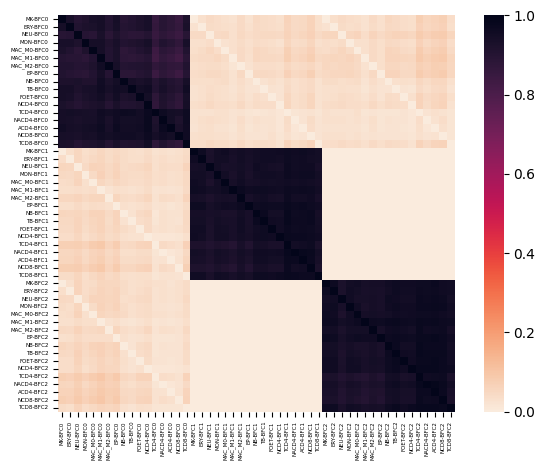

In [13]:
cm = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(isect_prop_df, square=True, cmap=cm, xticklabels=True, yticklabels=True)
plt.tick_params(axis='both', which='major', labelsize=4)
plt.tight_layout()
plt.savefig(IN_DIR + '/' + AUTHOR_SHORT + '_bfc_heatmap.pdf', bbox_inches='tight')

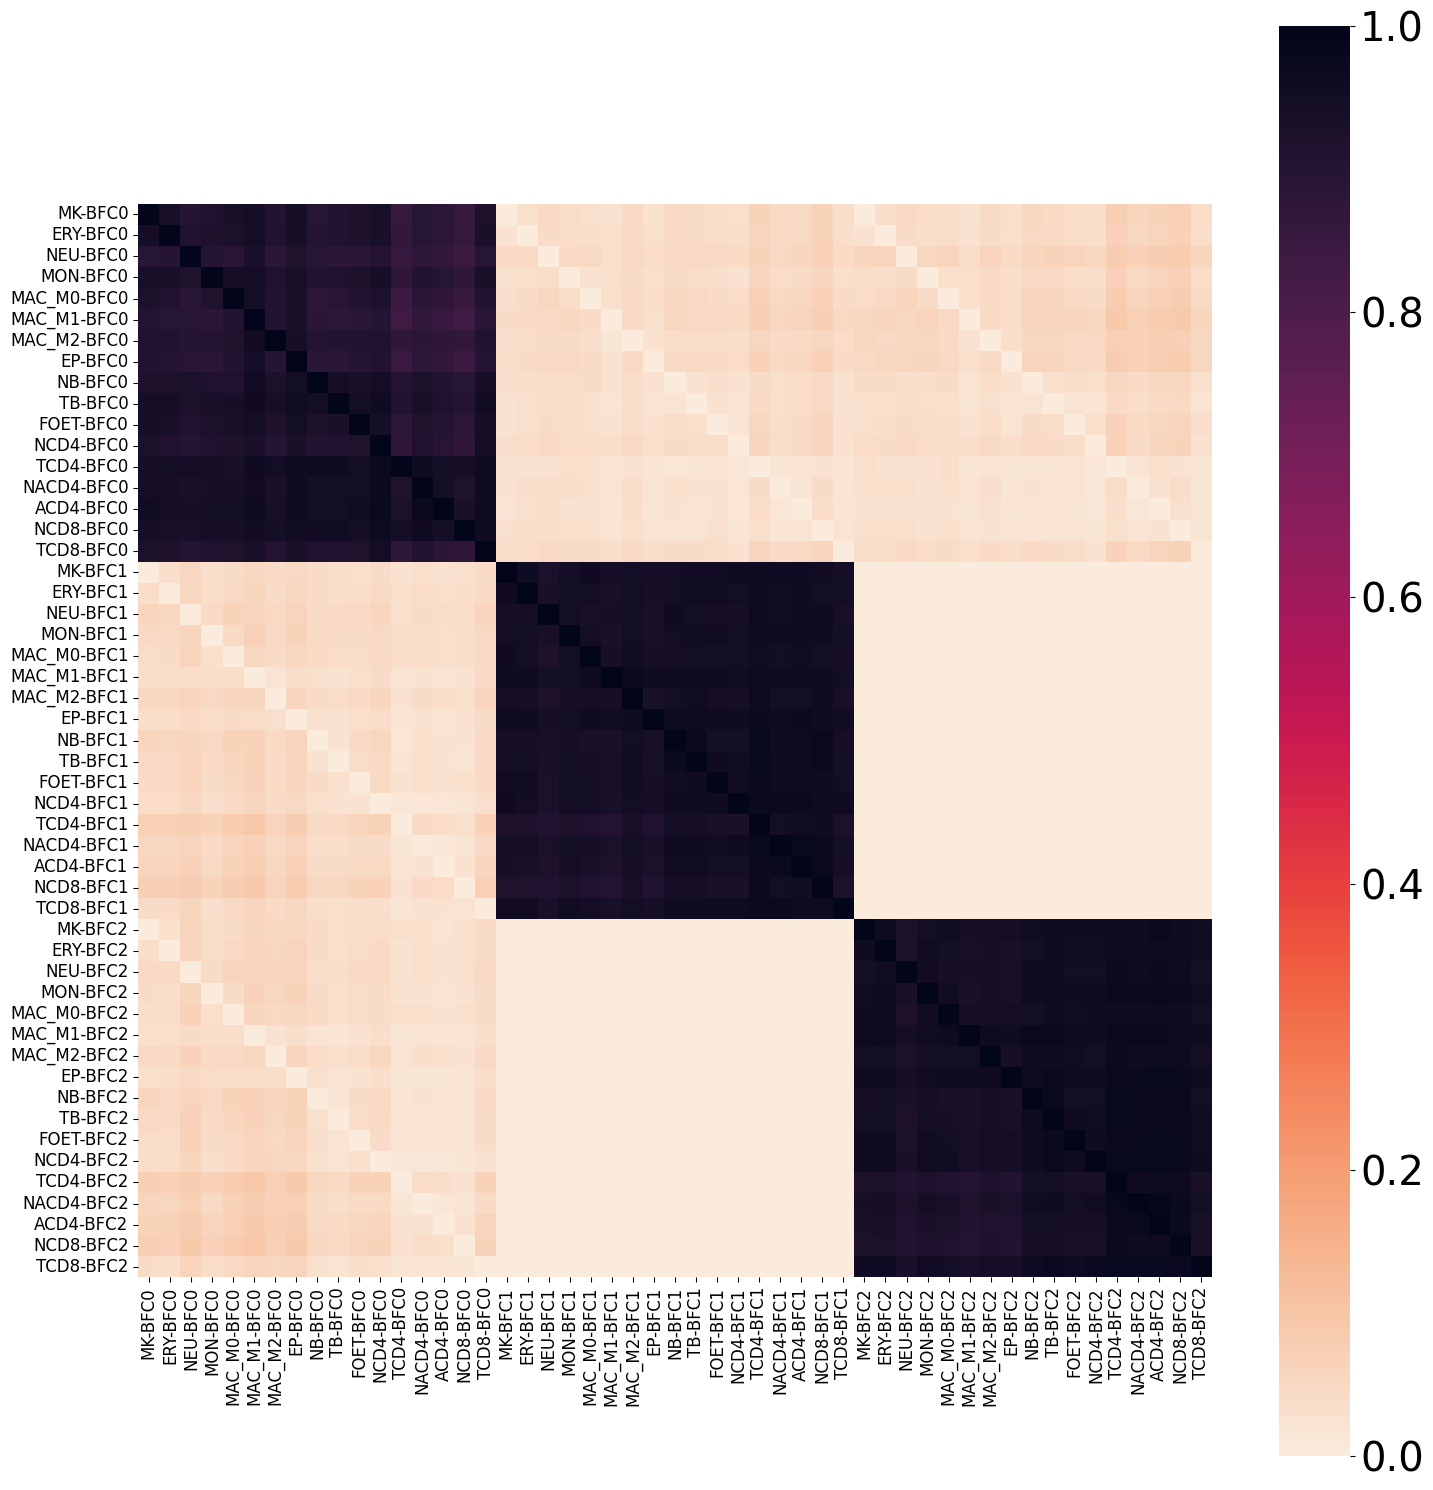

In [14]:
# Large heatmap for Javierre data
fig, ax = plt.subplots(figsize=(15,15))
cm = sns.color_palette("rocket_r", as_cmap=True)
ax = sns.heatmap(isect_prop_df, square=True, cmap=cm, xticklabels=True, yticklabels=True)
ax.tick_params(labelsize=12)
ax.figure.axes[-1].tick_params(labelsize=29)
plt.tight_layout()
plt.savefig(IN_DIR + '/' + AUTHOR_SHORT + '_bfc_heatmap.pdf', bbox_inches='tight')

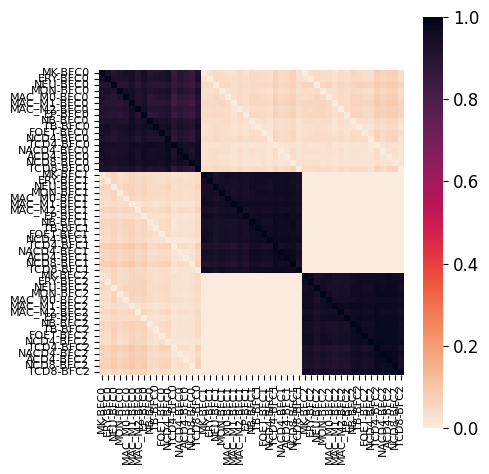

In [15]:
# Small heatmap for Schoenfelder data
fig, ax = plt.subplots(figsize=(5,5))
cm = sns.color_palette("rocket_r", as_cmap=True)
ax = sns.heatmap(isect_prop_df, square=True, cmap=cm, xticklabels=True, yticklabels=True)
ax.tick_params(labelsize=8)
ax.figure.axes[-1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(IN_DIR + '/' + AUTHOR_SHORT + '_bfc_heatmap_small.pdf', bbox_inches='tight')